In [1]:
! pip install transformers
! pip install seqeval

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange


## Load Data

In [3]:
train = pd.read_csv('data/tratados/train-AnatEM-BC5CDR.tsv', delimiter='\t', names=['word', 'label'], quoting=3, error_bad_lines=False)
test = pd.read_csv('data/tratados/test-AnatEM-BC5CDR.tsv', delimiter='\t', names=['word', 'label'], quoting=3, error_bad_lines=False)
devel = pd.read_csv('data/tratados/devel-AnatEM-BC5CDR.tsv', delimiter='\t', names=['word', 'label'], quoting=3, error_bad_lines=False)
print('Train labels: ', train.groupby('label').size())
print('Devel labels: ', devel.groupby('label').size())
print('Test labels: ', test.groupby('label').size())

Train labels:  label
B-Anatomy       6946
B-Chemical      5203
B-Disease       4182
I-Anatomy       4891
I-Chemical      1900
I-Disease       2918
O             245927
dtype: int64
Devel labels:  label
B-Anatomy       2139
B-Chemical      5347
B-Disease       4246
I-Anatomy       1416
I-Chemical      1748
I-Disease       2723
O             158617
dtype: int64
Test labels:  label
B-Anatomy       4616
B-Chemical      5378
B-Disease       4424
I-Anatomy       3243
I-Chemical      1628
I-Disease       2737
O             202684
dtype: int64


In [1]:
! nvidia-smi

/bin/bash: nvidia-smi: command not found


In [4]:
print(train.head(10))

             word label
0  Immunostaining     O
1             and     O
2        confocal     O
3        analysis     O
4             DNA     O
5       labelling     O
6             and     O
7        staining     O
8            with     O
9               5     O


In [5]:
# Separa o dataframe por PONTO-FINAL
def separar_frases(dataframe):
  sentences = []
  labels = []

  sentences_aux = []
  labels_aux = []

  inicio = True

  for word, label in zip(dataframe.word.values, dataframe.label.values):
    if inicio:
        sentences_aux.append('[CLS]')
        labels_aux.append('O')
        inicio = False
    sentences_aux.append(word)
    labels_aux.append(label)

    if (word == '.'):
        sentences_aux.append('[SEP]')
        labels_aux.append('O')
        
        sentences.append(sentences_aux)
        labels.append(labels_aux)
        
        sentences_aux = []
        labels_aux = []
        inicio = True

  return sentences, labels

In [6]:
train_sentences, train_labels = separar_frases(train)
test_sentences, test_labels = separar_frases(test)
devel_sentences, devel_labels = separar_frases(devel)

### Map tags to id 

In [7]:
tag_values = list(set(train["label"].values))
tag_values.append("PAD")
print(sorted(tag_values))
tag2idx = {t: i for i, t in enumerate(tag_values)}
print(tag2idx)

['B-Anatomy', 'B-Chemical', 'B-Disease', 'I-Anatomy', 'I-Chemical', 'I-Disease', 'O', 'PAD']
{'I-Disease': 0, 'B-Disease': 1, 'I-Anatomy': 2, 'B-Chemical': 3, 'B-Anatomy': 4, 'O': 5, 'I-Chemical': 6, 'PAD': 7}


## Prepare the sentences and labels

In [8]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.utils import shuffle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

print('Dispositivo:', device)
torch.cuda.get_device_name(0)

Dispositivo: cuda


'GeForce GTX 1650'

In [9]:
# Configura o tamanho máximo da sentenca e tamanho do batch de processamento
MAX_LEN = 75
bs = 8

## Tokenizar a entrada

In [10]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []
    for word, label in zip(sentence, text_labels):
#         print('sentence ', word)
        # Tokenize the word and count # of subwords the word is broken into
#         print(word)
#         break
        tokenized_word = tokenizer.tokenize(str(word))
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        if label.startswith("B"):
            labels.extend([label])
            new_label = "I-" + label[2:]

            labels.extend([new_label] * (n_subwords-1))
        else:
            labels.extend([label] * n_subwords)


    return tokenized_sentence, labels


In [11]:
tokenizer = BertTokenizer.from_pretrained('../models/biobert', do_lower_case=False)

train_tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(train_sentences, train_labels)
]
test_tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(test_sentences, test_labels)
]
devel_tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(devel_sentences, devel_labels)
]

print(train_tokenized_texts_and_labels[0])


(['[CLS]', 'I', '##mm', '##uno', '##sta', '##ining', 'and', 'con', '##fo', '##cal', 'analysis', 'DNA', 'label', '##ling', 'and', 'stain', '##ing', 'with', '5', '-', 'br', '##omo', '-', '2', "'", '-', 'de', '##ox', '##yu', '##rid', '##ine', '(', 'B', '##rd', '##U', 'label', '##ling', 'and', 'detection', 'kit', 'I', ';', 'Bo', '##eh', '##ring', '##er', 'Mann', '##heim', ',', 'Germany', ')', 'was', 'performed', 'according', 'to', 'the', 'manufacturer', "'", 's', 'instructions', '.', '[SEP]'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])


In [12]:
#Antigo
# train_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in train_tokenized_texts],
#                           maxlen=MAX_LEN, dtype="long", value=0.0,
#                           truncating="post", padding="post")
# test_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in test_tokenized_texts],
#                           maxlen=MAX_LEN, dtype="long", value=0.0,
#                           truncating="post", padding="post")
# devel_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in devel_tokenized_texts],
#                           maxlen=MAX_LEN, dtype="long", value=0.0,
#                           truncating="post", padding="post")

In [13]:
# refatorado
train_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(token[0]) for token in train_tokenized_texts_and_labels],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")
test_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(token[0]) for token in test_tokenized_texts_and_labels],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")
devel_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(token[0]) for token in devel_tokenized_texts_and_labels],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")
train_input_ids[0]

array([  101,   146,  6262, 26761,  8419, 16534,  1105, 14255, 14467,
        7867,  3622,  5394,  3107,  1979,  1105, 24754,  1158,  1114,
         126,   118,  9304, 18445,   118,   123,   112,   118,  1260,
       10649,  9379, 10132,  2042,   113,   139,  2956,  2591,  3107,
        1979,  1105, 11432, 11622,   146,   132,  9326, 10486,  3384,
        1200, 10852,  6797,   117,  1860,   114,  1108,  1982,  2452,
        1106,  1103,  7400,   112,   188,  7953,   119,   102,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0])

In [14]:
## presentação com PADids da tag das tags em tamanho de 75 (5 é PAD, 0 É O)

In [15]:
train_tags = pad_sequences([[tag2idx.get(l) for l in lab[1]] for lab in train_tokenized_texts_and_labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")
test_tags = pad_sequences([[tag2idx.get(l) for l in lab[1]] for lab in test_tokenized_texts_and_labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")
devel_tags = pad_sequences([[tag2idx.get(l) for l in lab[1]] for lab in devel_tokenized_texts_and_labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")
print(tag2idx)
print(train_tags[0])

{'I-Disease': 0, 'B-Disease': 1, 'I-Anatomy': 2, 'B-Chemical': 3, 'B-Anatomy': 4, 'O': 5, 'I-Chemical': 6, 'PAD': 7}
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 7 7 7 7 7 7 7 7 7 7 7 7
 7]


> train_tag[i] é a fita de tags normalizada (i.e., adicionando PAD tokens) para um tamanho = 75

In [16]:
train_attention_masks = [[float(i != 0.0) for i in ii] for ii in train_input_ids]
test_attention_masks = [[float(i != 0.0) for i in ii] for ii in test_input_ids]
devel_attention_masks = [[float(i != 0.0) for i in ii] for ii in devel_input_ids]
print(train_attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


> train_attention_masks[i]  é o vetor que diz ao BERT onde prestar atençao 

In [17]:
# tr_inputs, val_inputs, tr_tags, val_tags, tr_masks, val_masks = shuffle(train_input_ids, test_input_ids, train_tags, test_tags, train_attention_masks, test_attention_masks, random_state=2020)
# devel_inputs, devel_tags, devel_masks = shuffle(devel_input_ids, devel_tags, devel_attention_masks, random_state=2020)
# # pŕint(tr_inputs[0])
print(train_input_ids[0])
print(train_tags[0])
tr_inputs, tr_tags, tr_masks = shuffle(train_input_ids, train_tags, train_attention_masks, random_state=2020)
val_inputs, val_tags, val_masks = shuffle(test_input_ids, test_tags, test_attention_masks, random_state=2020)
devel_inputs, devel_tags, devel_masks = shuffle(devel_input_ids, devel_tags, devel_attention_masks, random_state=2020)

[  101   146  6262 26761  8419 16534  1105 14255 14467  7867  3622  5394
  3107  1979  1105 24754  1158  1114   126   118  9304 18445   118   123
   112   118  1260 10649  9379 10132  2042   113   139  2956  2591  3107
  1979  1105 11432 11622   146   132  9326 10486  3384  1200 10852  6797
   117  1860   114  1108  1982  2452  1106  1103  7400   112   188  7953
   119   102     0     0     0     0     0     0     0     0     0     0
     0     0     0]
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 7 7 7 7 7 7 7 7 7 7 7 7
 7]


In [18]:
# converter para ternsores
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)
devel_inputs = torch.tensor(devel_inputs)
devel_tags = torch.tensor(devel_tags)
devel_masks = torch.tensor(devel_masks)

In [19]:
# construir os DataLoader
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

devel_data = TensorDataset(devel_inputs, devel_masks, devel_tags)
devel_sampler = SequentialSampler(devel_data)
devel_dataloader = DataLoader(devel_data, sampler=devel_sampler, batch_size=bs)


In [20]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__


'3.5.1'

In [21]:
model = BertForTokenClassification.from_pretrained(
    "../models/biobert",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)


Some weights of the model checkpoint at ../models/biobert were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the

In [22]:
model.cuda();

In [23]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)


In [24]:
from transformers import get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [25]:
from seqeval.metrics import f1_score, accuracy_score


In [26]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []
validation_accuracy, validation_f1 = [], []
for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print()
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("Validation F1-Score: {}".format(f1_score([pred_tags], [valid_tags])))
    print()
    validation_accuracy.append(accuracy_score(pred_tags, valid_tags))
    validation_f1.append(f1_score([pred_tags], [valid_tags]))


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]


Average train loss: 0.1529447561052513
Validation loss: 0.12694689219502625
Validation Accuracy: 0.9585969954037599
Validation F1-Score: 0.7692828375131147



Epoch:  33%|███▎      | 1/3 [09:31<19:02, 571.13s/it]


Average train loss: 0.05089129587406746
Validation loss: 0.15465501329512163
Validation Accuracy: 0.9596040540250107
Validation F1-Score: 0.7908151079873075



Epoch:  67%|██████▋   | 2/3 [18:56<09:29, 569.55s/it]


Average train loss: 0.021152464882505488
Validation loss: 0.1806610095243646
Validation Accuracy: 0.9594689607953307
Validation F1-Score: 0.7947553522040495



Epoch: 100%|██████████| 3/3 [28:35<00:00, 571.94s/it]


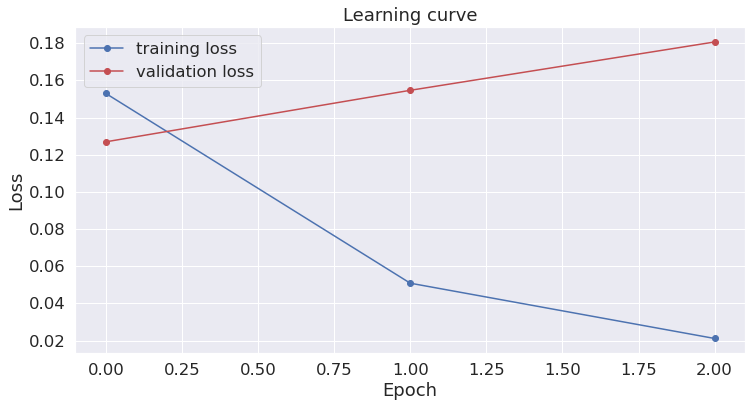

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.savefig('learning-curves')
plt.show()


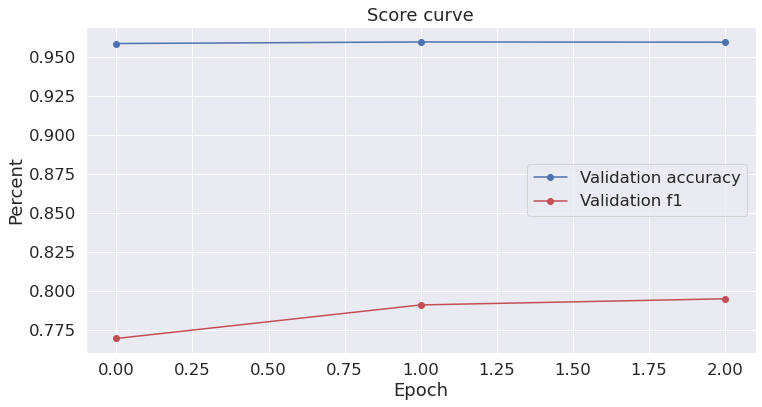

In [28]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(validation_accuracy, 'b-o', label="Validation accuracy")
plt.plot(validation_f1, 'r-o', label="Validation f1")
# Label the plot.
plt.title("Score curve")
plt.xlabel("Epoch")
plt.ylabel("Percent")
plt.legend()

plt.show()


In [29]:
model.eval()
# Reset the validation loss for this epoch.
devel_loss, devel_accuracy = 0, 0
nb_devel_steps, nb_devel_examples = 0, 0
predictions , true_labels = [], []
for batch in devel_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients,
    # saving memory and speeding up validation
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have not provided labels.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
    # Move logits and labels to CPU
    logits = outputs[1].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Calculate the accuracy for this batch of test sentences.
    devel_loss += outputs[0].mean().item()
    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    true_labels.extend(label_ids)

devel_loss = devel_loss / len(devel_dataloader)
print("Devel loss: {}".format(devel_loss))
pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                              for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
valid_tags = [tag_values[l_i] for l in true_labels
                              for l_i in l if tag_values[l_i] != "PAD"]
# print("Devel Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
# print("Devel F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
print()


Devel loss: 0.17615583823844405



In [44]:
# test_sentence = "This expression of NT-3 in supporting cells in embryos and neonates may even preserve in Brn3c null mutants the numerous spiral sensory neurons in the apex of 8-day old animals.Hypertensive pneumothorax is more common in tall and thin young adults (primary pneumothorax) or in patients with chronic pulmonary diseases or chest trauma (secondary pneumothorax)."
# test_sentence = 'The cardiac and pulmonary auscultation are normal; chest pain does not worse with palpation of the thorax; there is no jugular stasis nor lower limb edema.'

# test_sentence = 'The pain is continuous and is located just in the middle of my chest, worsening when I breathe and when I lay down on my bed, I suffer from arterial hypertension and smoke 20 cigarettes every day.'
# test_sentence = 'Sepsis is the second most common cause of death in non-coronary intensive care units and the tenth leading cause of death overall in high-income countries. During the past two decades, the incidence of sepsis has increased annually by 9% to reach 240 per 100 000 population in the USA by 2000.'
# test_sentence = 'The true incidence of sepsis in any given country is unknown. The reported incidence is dependent on the specific definition used, the infecting organism, the reporting mechanism (such as the use of the International Classification of Diseases-9 coding systems) and the requirement for either organ support or intensive care. These factors result in marked differences between estimates and discrete geographical locations. Most data describing the incidence of sepsis are from high-income countries, where 2.8 million deaths per year are attributable to sepsis. In 2001, Angus and colleagues reported in, the USA the, that incidence of severe sepsis was more than 750 000 cases per annum (300 cases per 100 000 population), equivalent to 2.26 cases per 100 hospital discharges. In the UK, the reported prevalence of sepsis in ICU-derived cohorts is 27% of all ICU admissions, whereas the prevalence is 12% in the USA. 14 This difference could partly be explained by the sub stantially greater numbers of ICU beds available in the USA than in the UK, and thus the differing triage patterns and admission criteria. It is also possible that, in institutions where clinical staff are trained in sepsis recognition, the previous use of the less-specific SIRS criteria could have led to an over-reporting of sepsis cases. Overall, however, there is probably a substantial under-reporting of the incidence of sepsis and with an ageing population, the incidence will continue to increase. This pattern might be further accentuated by campaigns to increase the awareness of and screening for the condition. Except for maternal and neonatal sepsis, the condition is usually considerably under-reported in the global burden of disease statistics. The true scale of the problem is probably much higher than what has been reported. Data suggest that sepsis contributes to between a third and a half of all in-hospital deaths in the USA. Although these data represent the incidence of sepsis in high-resource countries, most deaths due to sepsis happen in low-resource countries, where the exact incidence of sepsis is difficult to accurately estimate. The available literature suggests that an estimated 90% of worldwide deaths from chest infections occur in low-resource settings; about 70% of the 9 million deaths due to chest infections in neonates and infants are associated with sepsis, and most cases occur in Asia and Africa.'

# test_sentence = " Her eye is green. A 58-year-old African-American woman presents to the ER with episodic pressing/burning anterior chest pain that began two days earlier for the first time in her life. The pain started while she was walking, radiates to the eyes, and is accompanied by nausea, diaphoresis and mild dyspnea, but is not increased on inspiration. The latest episode of pain ended half an hour prior to her arrival. She is known to have hypertension and obesity. She denies smoking, diabetes, hypercholesterolemia, or a family history of heart disease. She currently takes no medications. Physical examination is normal. The EKG shows nonspecific changes. Alprazolan was administred."
test_sentence = 'My eye is blue. I feel nausea. '
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()
with torch.no_grad():
    output = model(input_ids)
# print(output)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    print(token, label_idx)
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)
for token, label in zip(new_tokens, new_labels):
    print("{}\t\t{}".format(label, token))

    

[CLS] 5
My 5
eye 5
is 5
blue 5
. 5
I 5
feel 5
nausea 1
. 5
[SEP] 5
O		[CLS]
O		My
O		eye
O		is
O		blue
O		.
O		I
O		feel
B-Disease		nausea
O		.
O		[SEP]


In [31]:
label_indices.shape

(1, 164)

In [32]:
# # label_list = ["O", "B-MISC", "I-MISC",  "B-PER", "I-PER", "B-ORG", "I-ORG", "B-LOC", "I-LOC", "[CLS]", "[SEP]"]

# import json, os

# # Save a trained model and the associated configuration
# model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
# model_to_save.save_pretrained('model')
# tokenizer.save_pretrained('model')
# label_map = {i : label for i, label in enumerate(tag_values,1)}        
# model_config = {"bert_model":"bert-base-cased","do_lower":False,"max_seq_length":128,"num_labels":len(tag_values)+1,"label_map":label_map}
# json.dump(model_config,open(os.path.join("model","model_config.json"),"w"))

In [33]:
model.save_pretrained("biobert_ner_AnatEM-BC5CDR")
tokenizer.save_pretrained('biobert_ner_AnatEM-BC5CDR')

# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD" -O biobert_weights && rm -rf /tmp/cookies.txt

('biobert_ner_AnatEM-BC5CDR/tokenizer_config.json',
 'biobert_ner_AnatEM-BC5CDR/special_tokens_map.json',
 'biobert_ner_AnatEM-BC5CDR/vocab.txt',
 'biobert_ner_AnatEM-BC5CDR/added_tokens.json')